### 신경망 성능 개선
신경망의 예측 성능 및 수렴 성능(gradient vanishing issue)을 개선하기 위해 추가 고려사항

- 오차함수 개선 : mean-squared error --> cross-entropy cost function 
- Activation 함수 변경 : sigmoid --> hyper-tangent, ReLu
- 가중치 초기화(Weight initialization)
- 정규화(Regularization) : L1, L2
- Softmax 출력
- Batch Normalization

In [1]:
from keras.datasets import mnist
from keras.utils import np_utils

(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

x_train = x_train0.reshape(x_train0.shape[0], x_train0.shape[1]*x_train0.shape[2]).astype('float32') / 255.0
x_test = x_test0.reshape(x_test0.shape[0], x_test0.shape[1]*x_test0.shape[2]).astype('float32') / 255.0
y_train = np_utils.to_categorical(y_train0, 10) # one-hot encoding & 종속변수의 카테고리(클래스)갯수
y_test = np_utils.to_categorical(y_test0,10) # one-hot encoding & 종속변수의 카테고리(클래스)갯수

In [2]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [3]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

##### 1. Cross-Entropy cost function
- 출력 레이어에서 활성화 함수의 도함수에 의한 영향 제거
- 즉, Output Layer에서 앞의 Hidden Layer로 갈때 gradient=0이 되는 걸 막아준다.(?)

In [7]:
np.random.seed(0)
model0 = Sequential()
model0.add(Dense(15, input_dim=784, activation='sigmoid'))
model0.add(Dense(10, activation='sigmoid'))
model0.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=['accuracy'])

In [8]:
hist0 = model0.fit(x_train, y_train, batch_size=100, epochs=30, validation_data=(x_test, y_test), verbose=0)

In [12]:
np.random.seed(0)
model1 = Sequential()
model1.add(Dense(15, input_dim=784, activation='sigmoid'))
model1.add(Dense(10, activation='sigmoid'))
# 바로 아래부분에서 loss를 categorical_crossentropy로 설정
model1.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
hist1 = model1.fit(x_train, y_train, epochs=30, batch_size=100, validation_data=(x_test, y_test), verbose=0)

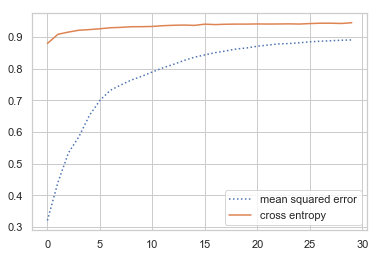

In [14]:
plt.plot(hist0.history['val_acc'], ls=':', label="mean squared error")
plt.plot(hist1.history['val_acc'], label="cross entropy")
plt.legend()
plt.show()

##### 2. Hyper-tangent activation function
- 기존의 sigmoid함수를 위아래로 잡아당기고, 좌우측에서 눌러 기울기를 급하게 만든 꼴

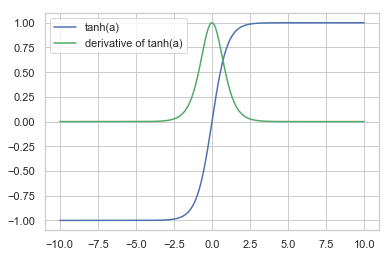

In [15]:
tanh = lambda x: np.tanh(x)
tanh_prime = lambda x : 1 - np.tanh(x) ** 2

xx = np.linspace(-10, 10, 1000)
plt.plot(xx, tanh(xx), 'b', label="tanh(a)")
plt.plot(xx, tanh_prime(xx), 'g-', label="derivative of tanh(a)")
plt.legend()
plt.show()

##### 3. ReLu : Rectified Linear Unit  activation function
- a값이 0보다 작으면 0으로 출력하고, 0보다 크면 그냥 내보낸다.
- 음수인 경우에 기울기가 0이 되지 않도록 하는 Leaky ReLu도 사용한다.

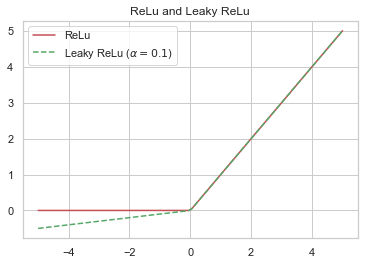

In [16]:
a = np.linspace(-5, 5, 100)
relu = np.maximum(0, a) # 0보다 작으면 0반환, 0보다 크면 a반환
leakrelu = np.maximum(0.1 * a, a)
plt.plot(a, relu, 'r-', label="ReLu")
plt.plot(a, leakrelu, 'g--', label="Leaky ReLu ($\\alpha=0.1$)")
plt.title("ReLu and Leaky ReLu")
plt.legend()
plt.show()

In [18]:
np.random.seed(0)
model2 = Sequential()
model2.add(Dense(15, input_dim=784, activation="tanh"))
model2.add(Dense(10, activation="sigmoid")) # 출력 레이어에선 sigmoid
model2.compile(optimizer=SGD(lr=0.2), loss="categorical_crossentropy", metrics=["accuracy"])

In [19]:
hist2 = model2.fit(x_train, y_train, epochs=30, batch_size=100, validation_data=(x_test, y_test), verbose=0)

In [20]:
np.random.seed(0)
model3 = Sequential()
model3.add(Dense(15, input_dim=784, activation="relu"))
model3.add(Dense(10, activation="sigmoid"))
model3.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=["accuracy"])

In [23]:
hist3 = model3.fit(x_train, y_train, epochs=30, batch_size=100, validation_data=(x_test, y_test), verbose=0)

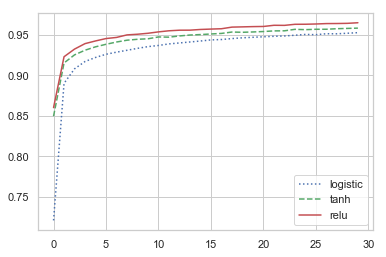

In [24]:
plt.plot(hist1.history['acc'], 'b:', label="logistic")
plt.plot(hist2.history['acc'], 'g--', label="tanh")
plt.plot(hist3.history['acc'], 'r-', label="relu")
plt.legend()
plt.show()

##### 4. Weight initialization(가중치 초기화)
- 이해하고 개념 정리 필요

In [26]:
np.random.seed(0)
model4 = Sequential()
model4.add(Dense(100, kernel_initializer='normal', activation='sigmoid', input_dim=784))
model4.add(Dense(10, kernel_initializer='normal', activation="sigmoid"))
model4.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [27]:
hist4 = model4.fit(x_train, y_train, epochs=10, batch_size=10, verbose=0)

In [28]:
np.random.seed(0)
model5 = Sequential()
model5.add(Dense(100, input_dim=784, activation="sigmoid", kernel_initializer="glorot_uniform"))
model5.add(Dense(10, activation="sigmoid", kernel_initializer="glorot_uniform"))
model5.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [30]:
hist5 = model5.fit(x_train, y_train, epochs=10, batch_size=10, verbose=0)

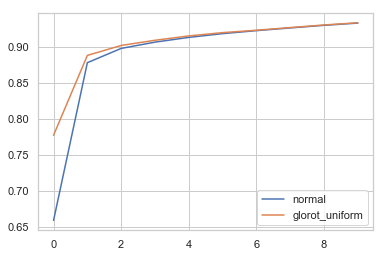

In [31]:
plt.plot(hist4.history['acc'], label="normal")
plt.plot(hist5.history['acc'], label="glorot_uniform")
plt.legend()
plt.show()

### 과최적화 문제
- Parameter의 갯수가 너무 많으면 과최적화 발생가능성이 증가한다.--> 정확도 향상안됨.

In [32]:
np.random.seed(0)
model6 = Sequential()
model6.add(Dense(30, input_dim=784, activation="sigmoid"))
model6.add(Dense(10, activation="sigmoid"))
model6.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

In [33]:
hist6 = model6.fit(x_train, y_train, epochs=30, batch_size=10, validation_data=(x_test, y_test), verbose=0)

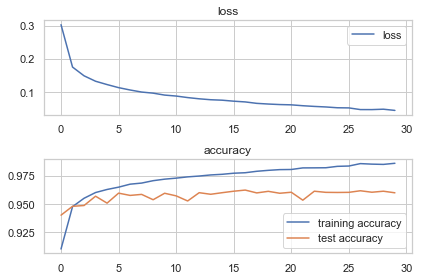

In [35]:
plt.subplot(211)
plt.plot(hist6.history['loss'], label="loss")
plt.legend()
plt.title("loss")

plt.subplot(212)
plt.plot(hist6.history['acc'], label="training accuracy")
plt.plot(hist6.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

- L1/L2, Dropout 정규화 실시

##### 5. L1, L2 정규화

In [36]:
from keras import regularizers

np.random.seed(0)
model7 = Sequential()
model7.add(Dense(30, input_dim=784, activation="sigmoid", kernel_regularizer=regularizers.l2(0.0001)))
model7.add(Dense(10, activation="sigmoid"))
model7.compile(optimizer=SGD(lr=0.5), loss="categorical_crossentropy", metrics=["accuracy"])

In [37]:
hist7 = model7.fit(x_train, y_train, epochs=30, batch_size=10, validation_data=(x_test, y_test), verbose=0)

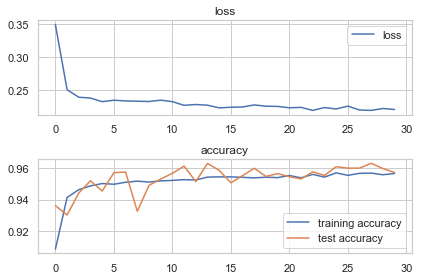

In [38]:
plt.subplot(211)
plt.plot(hist7.history['loss'], label="loss")
plt.legend()
plt.title("loss")
plt.subplot(212)
plt.plot(hist7.history['acc'], label="training accuracy")
plt.plot(hist7.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

정규화 전에 비해 test accuracy가 좋아졌다

In [39]:
from keras.layers import Dropout

In [40]:
np.random.seed(0)
model8 = Sequential()
model8.add(Dense(30, input_dim=784, activation="sigmoid"))
model8.add(Dropout(0.1)) # 0.1은 hidden layer의 총 뉴런중에 90퍼만 사용하겠다는 의미(10퍼는 drop)
model8.add(Dense(10, activation="sigmoid"))
model8.compile(optimizer=SGD(lr=0.5), loss="categorical_crossentropy", metrics=["accuracy"])

In [41]:
hist8 = model8.fit(x_train, y_train, epochs=30, batch_size=10, validation_data=(x_test, y_test), verbose=0)

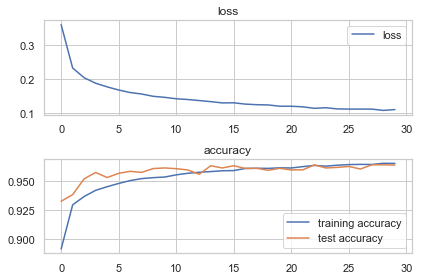

In [42]:
plt.subplot(211)
plt.plot(hist8.history['loss'], label="loss")
plt.legend()
plt.title("loss")
plt.subplot(212)
plt.plot(hist8.history['acc'], label="training accuracy")
plt.plot(hist8.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

L2 regularization했을때보다 더 좋아진 것 같다.